In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:
def trend(time,slope=0):
    return slope*time

In [4]:
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

In [5]:
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

In [6]:
# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [8]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

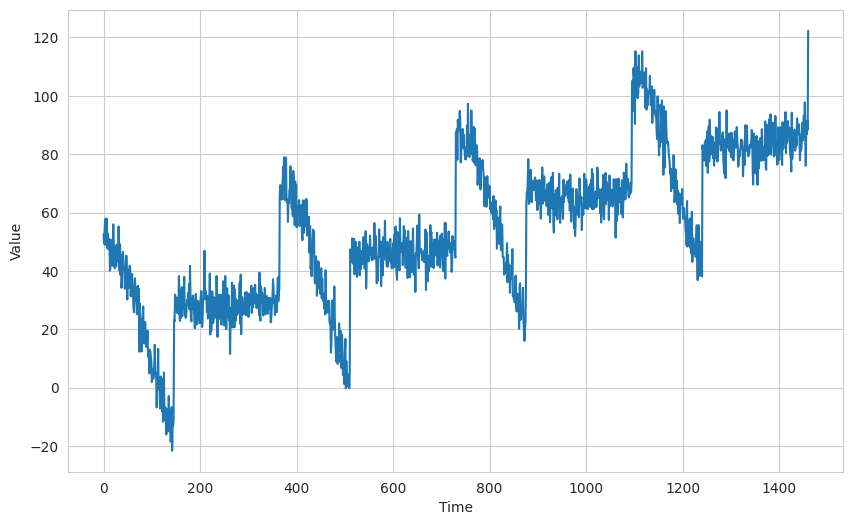

In [9]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [10]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [13]:
train_set = window_dataset(X_train,window_size)

In [14]:
valid_set = window_dataset(X_valid,window_size)

In [15]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [16]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [17]:
model.fit(train_set,epochs=10,validation_data=valid_set)

Epoch 1/10
31/31 [==============================] - 1s 17ms/step - loss: 36.2539 - mae: 36.7509 - val_loss: 22.7126 - val_mae: 23.2126
Epoch 2/10
31/31 [==============================] - 0s 7ms/step - loss: 13.3632 - mae: 13.8529 - val_loss: 10.6995 - val_mae: 11.1930
Epoch 3/10
31/31 [==============================] - 0s 9ms/step - loss: 12.2171 - mae: 12.7064 - val_loss: 10.3969 - val_mae: 10.8872
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 11.7751 - mae: 12.2639 - val_loss: 10.0055 - val_mae: 10.4908
Epoch 5/10
31/31 [==============================] - 0s 11ms/step - loss: 11.3662 - mae: 11.8572 - val_loss: 9.6740 - val_mae: 10.1600
Epoch 6/10
31/31 [==============================] - 1s 21ms/step - loss: 11.1063 - mae: 11.5962 - val_loss: 9.4794 - val_mae: 9.9687
Epoch 7/10
31/31 [==============================] - 0s 14ms/step - loss: 10.6873 - mae: 11.1760 - val_loss: 9.1883 - val_mae: 9.6800
Epoch 8/10
31/31 [==============================] - 0s 14ms/ste

In [18]:
# Tunning

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [20]:
train_set = window_dataset(X_train,window_size)

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [22]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6*10**(epoch/30))

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

In [24]:
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [25]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 18.2022 - mae: 18.6981 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 10.5345 - mae: 11.0259 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 9.8751 - mae: 10.3640 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 9.8186 - mae: 10.3078 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 9.7382 - mae: 10.2271 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 9.6548 - mae: 10.1430 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.5749 - mae: 10.0626 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 9.5053 - mae: 9.9935 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 9.3821 - mae: 9.8685 - lr: 1

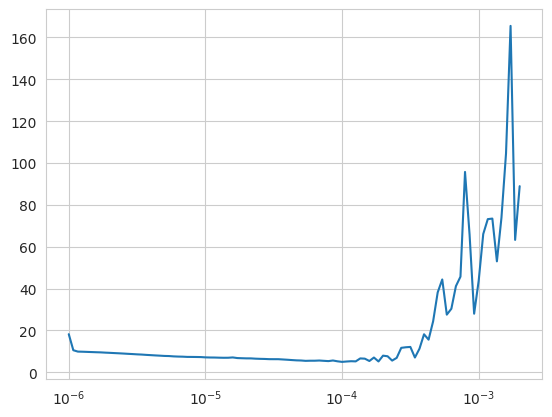

In [26]:
plt.semilogx(history.history['lr'],history.history['loss'])
#plt.axis(1e-6,1e-3,0,20)
plt.show()

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [28]:
train_set = window_dataset(X_train,window_size)
valid_set = window_dataset(X_valid,window_size)

In [29]:
model = keras.models.Sequential([
    keras.layers.Dense(1,input_shape=[window_size])
])

In [30]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [31]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,validation_data=valid_set,callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 15.2219 - mae: 15.7143 - val_loss: 10.2000 - val_mae: 10.6863
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 10.4269 - mae: 10.9140 - val_loss: 9.7086 - val_mae: 10.1971
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 9.5419 - mae: 10.0284 - val_loss: 9.5847 - val_mae: 10.0702
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 9.0648 - mae: 9.5518 - val_loss: 9.2336 - val_mae: 9.7166
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 8.8535 - mae: 9.3393 - val_loss: 9.0763 - val_mae: 9.5646
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 8.5911 - mae: 9.0739 - val_loss: 8.7082 - val_mae: 9.1934
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 8.4732 - mae: 8.9581 - val_loss: 8.5880 - val_mae: 9.0742
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 

In [32]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [33]:
lin_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 5ms/step


In [34]:
lin_forecast

array([ 64.9806  ,  67.29029 ,  70.10905 ,  68.43087 ,  64.60036 ,
        67.12156 ,  65.30194 ,  67.343636,  67.848724,  67.94543 ,
        65.29098 ,  68.18654 ,  68.11517 ,  70.70741 ,  65.94117 ,
        69.78093 ,  66.852234,  67.94358 ,  64.09475 ,  64.06809 ,
        63.91138 ,  65.32986 ,  64.347015,  66.33965 ,  66.34254 ,
        69.87183 ,  69.13802 ,  69.220215,  68.27974 ,  67.34179 ,
        65.81453 ,  64.901245,  60.472706,  63.361996,  62.895157,
        65.20059 ,  66.91956 ,  63.484856,  63.500225,  63.838898,
        66.17654 ,  68.882935,  65.376076,  67.95942 ,  66.36483 ,
        67.81705 ,  68.29526 ,  67.20191 ,  65.39533 ,  66.361694,
        67.98884 ,  70.3715  ,  64.97634 ,  65.744896,  67.571846,
        66.29043 ,  66.18254 ,  64.493546,  65.69519 ,  66.8635  ,
        65.63821 ,  69.36057 ,  63.071423,  64.06898 ,  62.881714,
        64.22055 ,  60.107346,  62.602608,  62.879715,  63.87925 ,
        65.65695 ,  64.88912 ,  66.71548 ,  68.17098 ,  64.494

In [35]:
lin_forecast.shape

(461,)

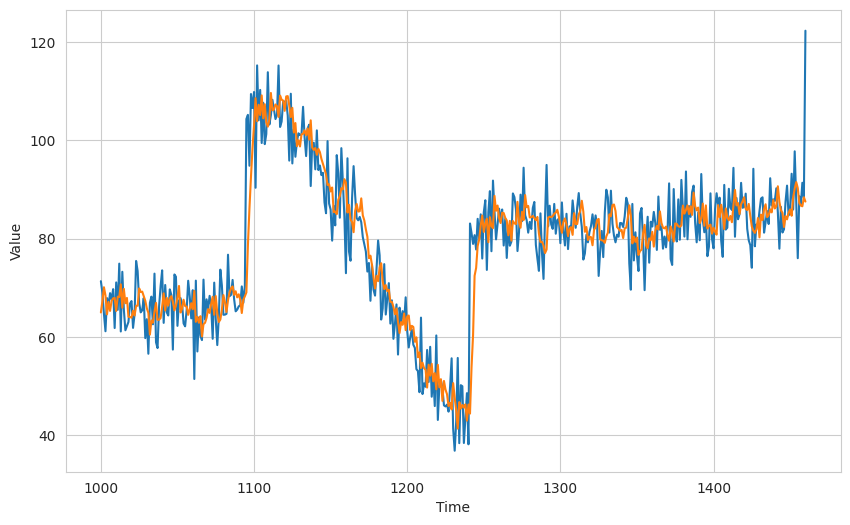

In [36]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,lin_forecast)

In [37]:
# Dense Model

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [39]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [40]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [41]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 12.4472 - mae: 12.9411 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 11.6874 - mae: 12.1805 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 10.8227 - mae: 11.3150 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 9.9367 - mae: 10.4298 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 9.0316 - mae: 9.5220 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 8.1710 - mae: 8.6587 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 7.4285 - mae: 7.9172 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 6.8611 - mae: 7.3499 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 6.4788 - mae: 6.9606 - lr: 2.511

(1e-07, 0.005, 0.0, 30.0)

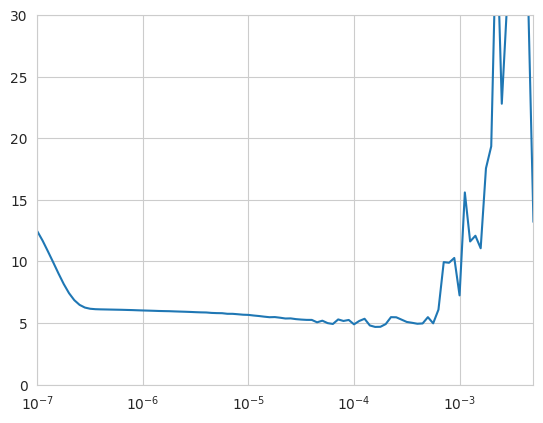

In [42]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,5e-3,0,30])

In [43]:
# tunning

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size)

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(10,activation='relu',input_shape=[window_size]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1)
])

In [46]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [47]:
early_stooping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stooping])

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 14.7039 - mae: 15.1991 - val_loss: 10.9303 - val_mae: 11.4259
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 7.5572 - mae: 8.0417 - val_loss: 6.2931 - val_mae: 6.7751
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 6.8290 - mae: 7.3160 - val_loss: 5.9814 - val_mae: 6.4581
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 6.5521 - mae: 7.0336 - val_loss: 5.8563 - val_mae: 6.3385
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 6.3947 - mae: 6.8778 - val_loss: 5.7516 - val_mae: 6.2294
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 6.3328 - mae: 6.8178 - val_loss: 5.7261 - val_mae: 6.2111
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 6.2663 - mae: 6.7452 - val_loss: 5.6419 - val_mae: 6.1201
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 6.216

In [48]:
dense_forcast = model_forcast(model,
                             series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 6ms/step


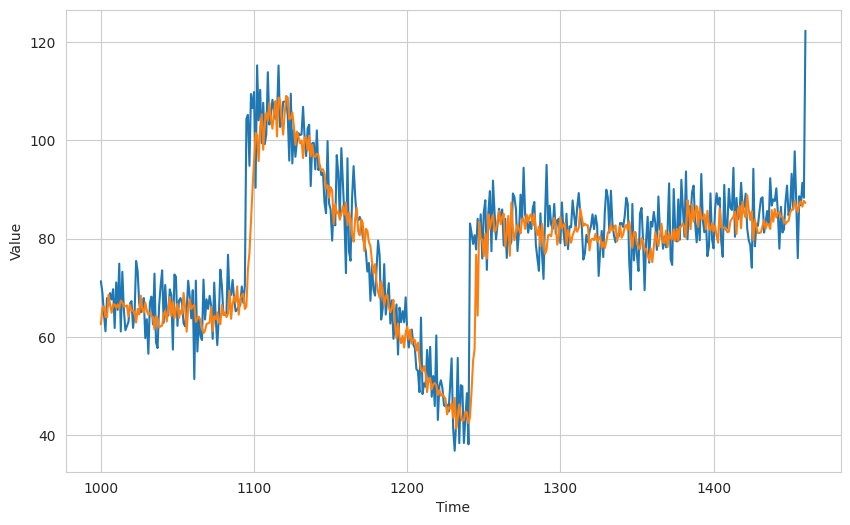

In [49]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,dense_forcast)

In [50]:
keras.metrics.mean_absolute_error(X_valid,dense_forcast).numpy()

5.0740333